In [1]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataset_path = "/content/drive/MyDrive/Dataset"

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path, shuffle=True, image_size  = (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 1610 files belonging to 3 classes.


In [6]:
classname = dataset.class_names

In [7]:
classname

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for image_batch , labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 0 0 0 2 0 1 0 1 1 0 0 0 2 2 1 1 0 1 0 0 0 0 0 2 0 0 1]


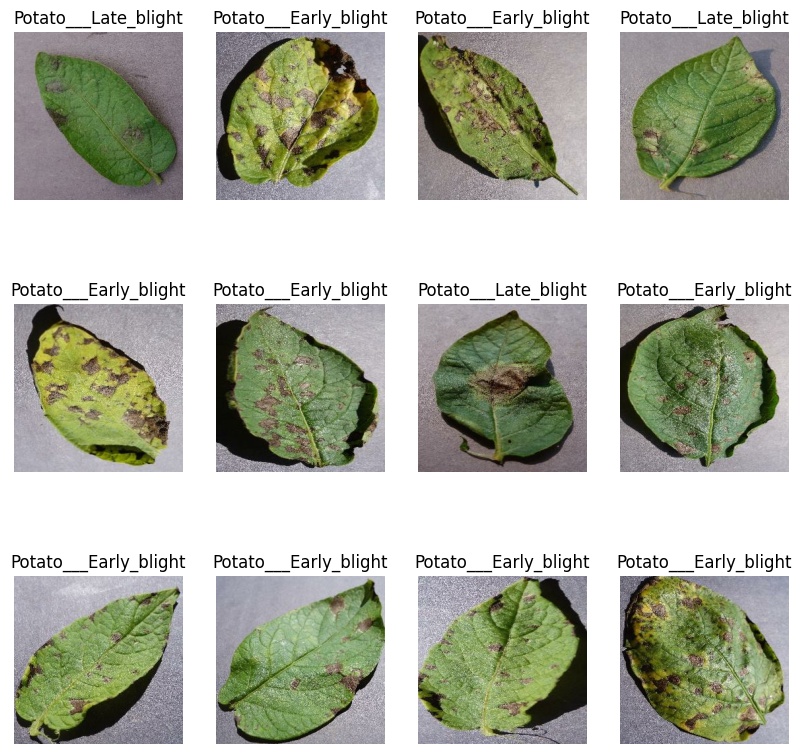

In [9]:
plt.figure(figsize=(10,10))
for image_batch , labels_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classname[labels_batch[i]])
    plt.axis("off")

**SPLITTING THE DATASET**
1. Training
2. Validation
3. Testing

In [10]:
len(dataset)

51

In [11]:
train_size = 0.8
train_ds = dataset.take(int(len(dataset) * train_size))
len(train_ds)

40

In [12]:
test_ds = dataset.skip(int(len(dataset) * train_size))
len(test_ds)

11

In [13]:
val_size = 0.1
val_ds = test_ds.take(int(len(dataset) * val_size))
test_ds = test_ds.skip(int(len(dataset) * val_size))

print(f"Number of validation batches: {len(val_ds)}")
print(f"Number of test batches: {len(test_ds)}")

Number of validation batches: 5
Number of test batches: 6


In [14]:
train_split = 0.8
val_split = 0.1
test_split = 0.1

assert train_split + val_split + test_split == 1

In [15]:
def get_dataset_paratitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split + val_split + test_split == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds , val_ds , test_ds = get_dataset_paratitions_tf(dataset)

In [17]:
len(train_ds)

40

In [18]:
len(val_ds)

5

In [19]:
len(test_ds)

6

Cache , Shuffle and Prefetch the dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Data Resizing & Normalization

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

Data Agumentation

In [22]:
data_augmenation  = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [23]:
train_ds = train_ds.map(
lambda x, y : (data_augmenation(x, training=True), y)).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),

    layers.Dense(n_classes, activation='softmax'),

])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs = 10,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 583ms/step - accuracy: 0.5785 - loss: 0.8966 - val_accuracy: 0.6062 - val_loss: 0.8297
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 362ms/step - accuracy: 0.6386 - loss: 0.7833 - val_accuracy: 0.7250 - val_loss: 0.6091
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.7436 - loss: 0.6406 - val_accuracy: 0.8188 - val_loss: 0.4171
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.8270 - loss: 0.3986 - val_accuracy: 0.8500 - val_loss: 0.3120
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.8812 - loss: 0.2944 - val_accuracy: 0.9187 - val_loss: 0.2613
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.8765 - loss: 0.2809 - val_accuracy: 0.8625 - val_loss: 0.2514
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step - accuracy: 0.8803 - loss: 0.2919 - val_accuracy: 0.9187 - val_loss: 0.1917
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step - accuracy: 0.9108 - loss: 0.2270 - val_acc

In [28]:
scores = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8963 - loss: 0.2300


In [29]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 40}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
type(history.history['loss'])

list

In [32]:
len(history.history['loss'])

10

In [33]:

acc = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [34]:
val_acc

[0.606249988079071,
 0.7250000238418579,
 0.8187500238418579,
 0.8500000238418579,
 0.918749988079071,
 0.862500011920929,
 0.918749988079071,
 0.90625,
 0.9375,
 0.9125000238418579]

In [39]:
model.save('image_classifier_model.h5')

Text(0.5, 1.0, 'Training & Validation Loss')

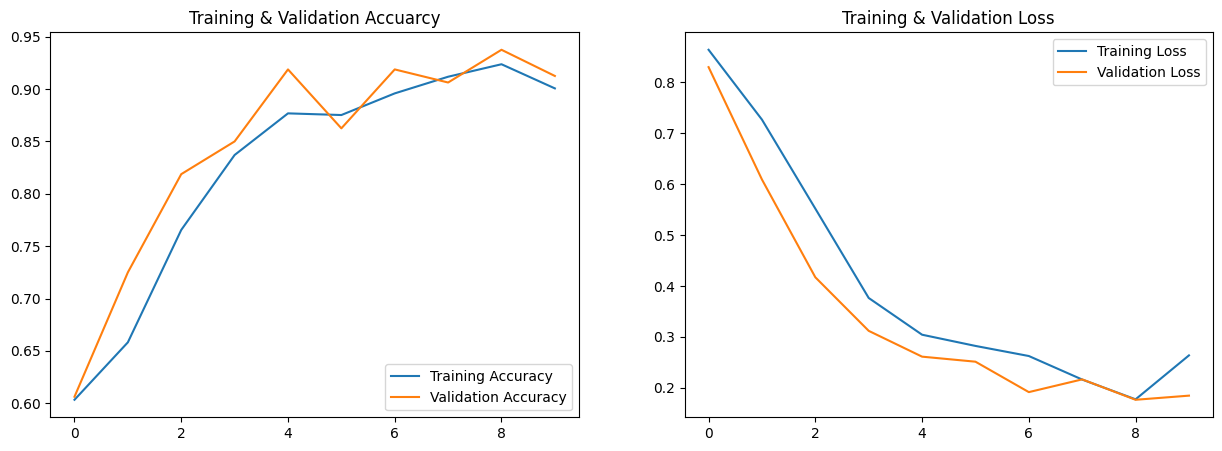

In [35]:

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label = "Training Accuracy")
plt.plot(range(10), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title('Training & Validation Accuarcy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label = "Training Loss")
plt.plot(range(10), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title('Training & Validation Loss')

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
predicted label: Potato___Early_blight


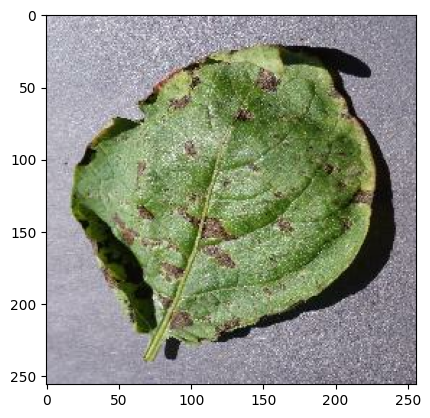

In [36]:

import numpy as np
for image_batch , labels_batch in test_ds.take(1):
    first_img = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_img)
    print('actual label:', classname[first_label])

    batch_prediction = model.predict(image_batch)
    print('predicted label:', classname[np.argmax(batch_prediction[0])])

In [37]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)

    predicted_class = classname[np.argmax(prediction[0])]
    confidence = round(100 * (np.argmax(prediction[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


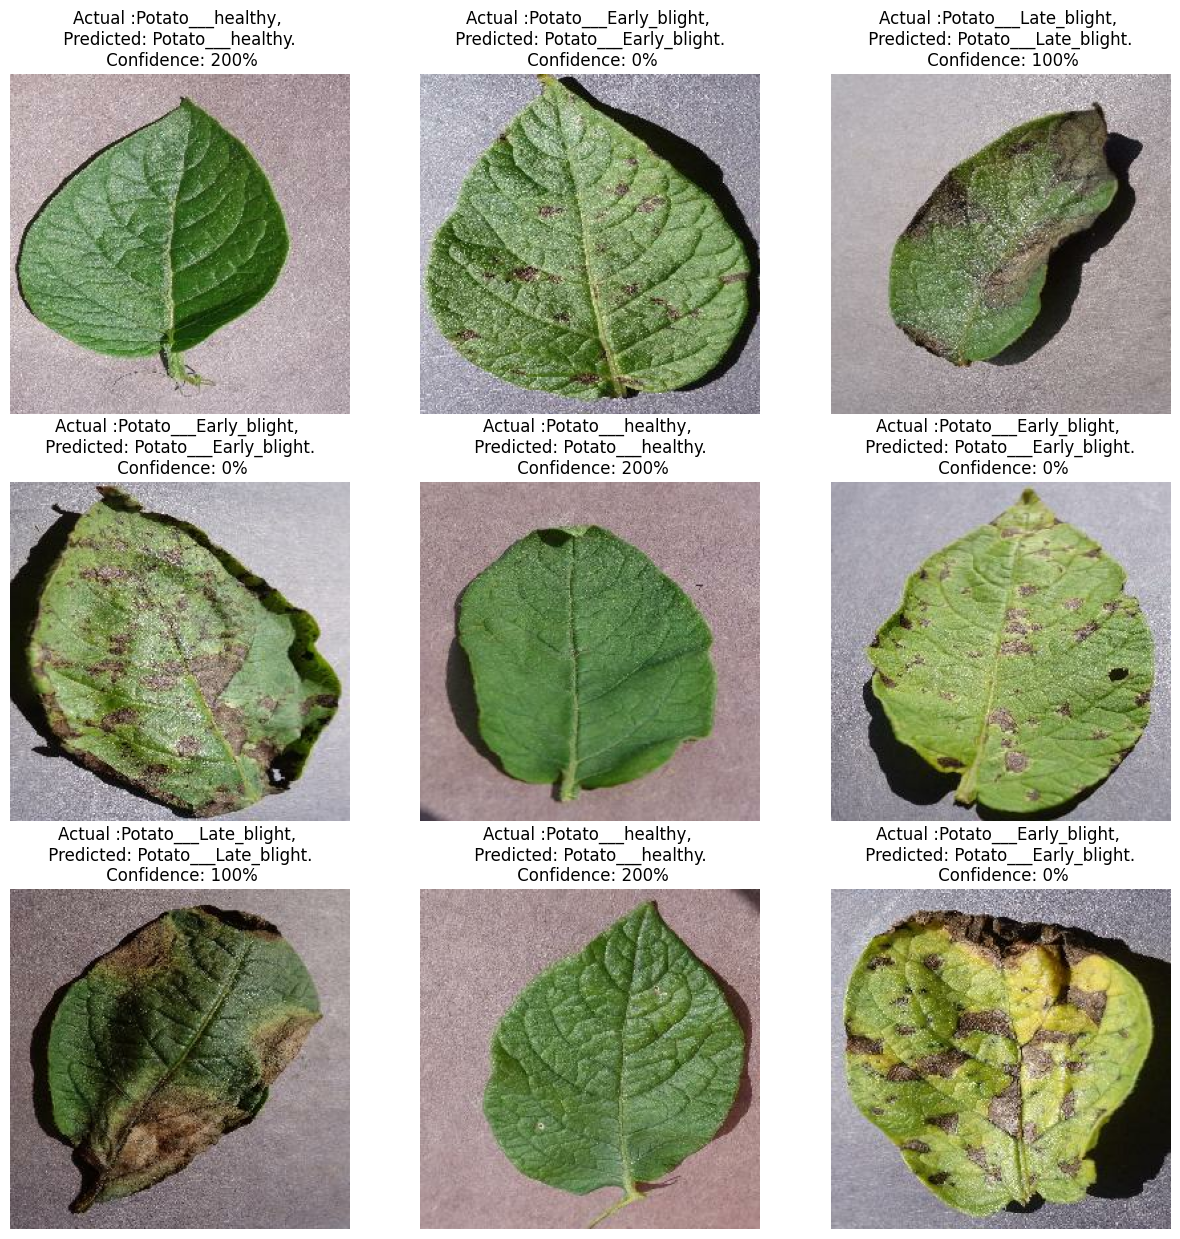

In [38]:

plt.figure(figsize = (15,15))

for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3 ,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i])
        actual_class = classname[labels[i]]

        plt.title(f"Actual :{actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")

        plt.axis("off")